In [4]:
# import PIL
# from keras import models
# from keras import layers
# from tensorflow.keras import optimizers
# import os
# import glob
# import shutil
# import sys
# import numpy as np
# from skimage.io import imread
# import matplotlib.pyplot as plt
# import os
# from tensorflow.keras import callbacks
# import pandas as pd
# from keras.utils import generic_utils


# os.environ["CUDA_VISIBLE_DEVICES"]=""

# # Define the input shapes for the two images
# img_height, img_width, channels = 225, 225, 3

# # Define the input layers for the two images
# input_img1 = Input(shape=(img_height, img_width, channels))
# input_img2 = Input(shape=(img_height, img_width, channels))

# # Concatenate the two input images along the channel axis
# concatenated_input = Concatenate(axis=-1)([input_img1, input_img2])

In [15]:
from keras import models
from keras import layers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Concatenate, Input, Conv2D, BatchNormalization

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [16]:
import efficientnet.tfkeras as efn
conv_base = efn.EfficientNetB5(weights='imagenet')


# # Define the input shapes for the two images
# height = width = conv_base.input_shape[1]

# # Define the input layers for the two images
# input_img1 = (height, width, 3)
# input_img2 = (height, width, 3)

# Define the input shapes for the two images
img_height, img_width, channels = 456, 456, 3

# Define the input layers for the two images
input_img1 = Input(shape=(img_height, img_width, channels))
input_img2 = Input(shape=(img_height, img_width, channels))

# Concatenate the two input images along the channel axis
concatenated_input = Concatenate(axis=-1)([input_img1, input_img2])

# Create a new input layer that accommodates the concatenated input tensor
new_input = Conv2D(3, (1, 1), activation='relu')(concatenated_input)
new_input = BatchNormalization()(new_input)

# loading pretrained conv base model
conv_base = efn.EfficientNetB5(weights='imagenet', include_top=False)

# Use the base model as a layer in your custom model
conv_base_modify = conv_base(new_input)

# x = conv_base.output
# # create new model with a new classification layer
x = layers.GlobalAveragePooling2D(name = 'head_pooling')(conv_base_modify)
x = layers.Dropout(0.50,name = 'head_dropout')(x)
x = layers.Dense(2, activation='softmax',name = 'prediction_layer')(x)

# x = x(conv_base_modify)

model = models.Model(inputs=[input_img1, input_img2], outputs=x)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 456, 456, 6)  0           input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 456, 456, 3)  21          concatenate_2[0][0]        

In [17]:
# x = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
# x = layers.Dropout(0.50,name = 'head_dropout')(x)
# x = layers.Dense(2, activation='softmax',name = 'prediction_layer')(x)

# model = models.Model(inputs=new_input, outputs=x)
# model.summary()

In [18]:
conv_base(new_input)

<KerasTensor: shape=(None, 15, 15, 2048) dtype=float32 (created by layer 'efficientnet-b5')>

In [19]:
conv_base.output 

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'top_activation')>

In [20]:
conv_base.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_12')>

In [21]:
new_input

<KerasTensor: shape=(None, 456, 456, 3) dtype=float32 (created by layer 'batch_normalization_2')>

In [22]:
# Total params: 28,517,618
# Trainable params: 28,344,882
# Non-trainable params: 172,736

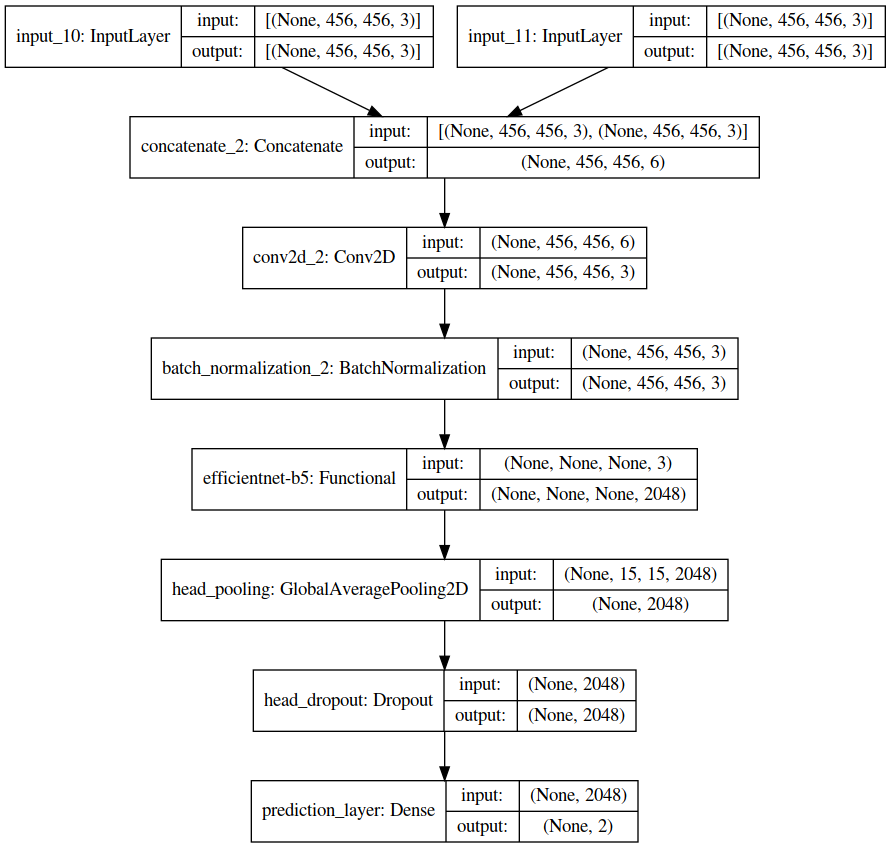

In [23]:
# from keras.models import Sequential
# from keras.layers import Dense
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=1, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#showing before&after freezing
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in conv_base.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))  

This is the number of trainable layers before freezing the conv base: 510
This is the number of trainable layers after freezing the conv base: 6


In [25]:
#ต้องแก้ตรงนี้ให้ได้เพื่อ Unfreeze

In [26]:
# Unfreeze
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5a_se_excite':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))  


This is the number of trainable layers after freezing the conv base: 246


In [ ]:
# Compile the model with a lower learning rate
final_model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history = final_model.fit(
    x=[train_dataset['img1'], train_dataset['img2']],
    y=train_dataset['label'],
    epochs=10,
    validation_data=([val_dataset['img1'], val_dataset['img2']], val_dataset['label']),
    batch_size=32
)

In [ ]:
# Assume you have a dataset with two input images and a corresponding label
train_dataset = ...
val_dataset = ...

# Compile the model
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = final_model.fit(
    x=[train_dataset['img1'], train_dataset['img2']],
    y=train_dataset['label'],
    epochs=10,
    validation_data=([val_dataset['img1'], val_dataset['img2']], val_dataset['label']),
    batch_size=32
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [9]:
# from efficientnet.keras import EfficientNetB5 as Net
# from efficientnet.keras import center_crop_and_resize, preprocess_input

# import efficientnet.tfkeras as efn
# conv_base = efn.EfficientNetB5(weights='imagenet')
# height = width = conv_base.input_shape[1]
# input_shape = (height, width, 3)

# # loading pretrained conv base model
# conv_base = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
# # create new model with a new classification layer
# x = conv_base.output  
# global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
# dropout_layer_1 = layers.Dropout(0.50,name = 'head_dropout')(global_average_layer)
# prediction_layer = layers.Dense(2, activation='softmax',name = 'prediction_layer')(dropout_layer_1)

# model = models.Model(inputs= conv_base.input, outputs=prediction_layer) 
# model.summary()

In [8]:
# Define the input shapes for the two images
img_height, img_width, channels = 456, 456, 3

# Define the input layers for the two images
input_img1 = Input(shape=(img_height, img_width, channels))
input_img2 = Input(shape=(img_height, img_width, channels))

# Concatenate the two input images along the channel axis
concatenated_input = Concatenate(axis=-1)([input_img1, input_img2])

# Create a new input layer that accommodates the concatenated input tensor
new_input = Conv2D(3, (1, 1), activation='relu')(concatenated_input)
new_input = BatchNormalization()(new_input)

# Create the EfficientNet B5 model
base_model = EfficientNetB5(weights='imagenet', include_top=False)

# Use the base model as a layer in your custom model
x = base_model(new_input)

# # Add a classification head on top of the model
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(2, activation='softmax')(x)
x = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
x = layers.Dropout(0.50,name = 'head_dropout')(x)
x = layers.Dense(2, activation='softmax',name = 'prediction_layer')(x)

# create new model with a new classification layer
# x = base_model.output  
# global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
# dropout_layer_1 = layers.Dropout(0.50,name = 'head_dropout')(global_average_layer)
# prediction_layer = layers.Dense(2, activation='softmax',name = 'prediction_layer')(dropout_layer_1)

# Define the final model
final_model = models.Model(inputs=[input_img1, input_img2], outputs=x)

In [9]:
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 456, 456, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 456, 456, 3)  21          concatenate_4[0][0]        

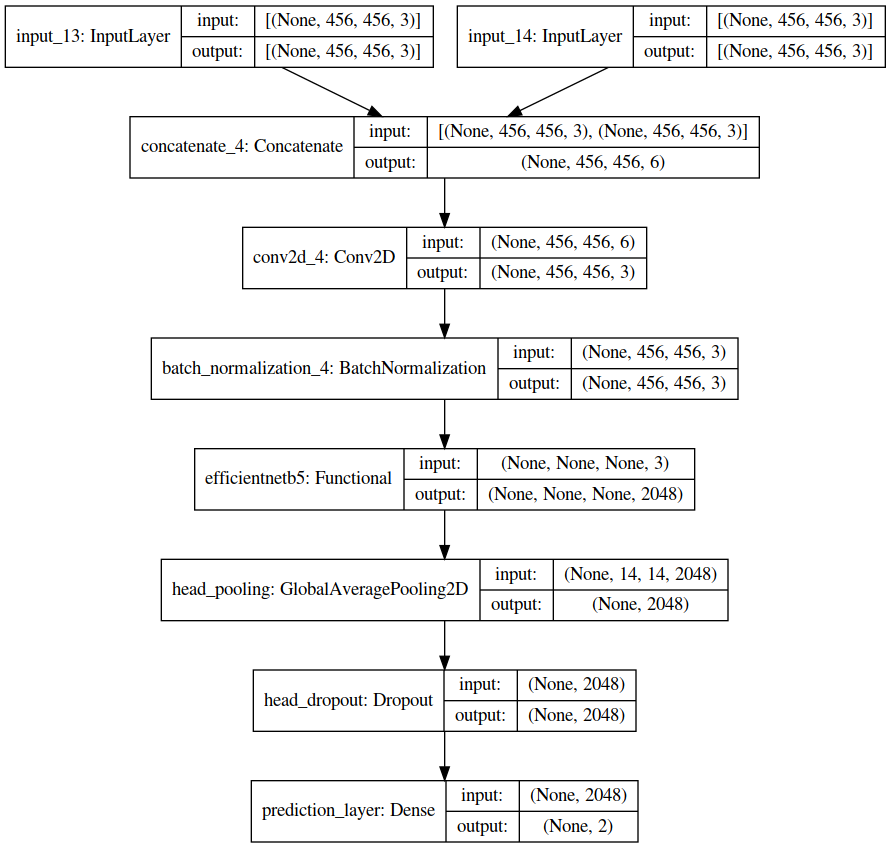

In [10]:
# from keras.models import Sequential
# from keras.layers import Dense
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=1, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
#showing before&after freezing
print('This is the number of trainable layers '
      'before freezing the conv base:', len(final_model.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in base_model.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(final_model.trainable_weights))  

This is the number of trainable layers before freezing the conv base: 510
This is the number of trainable layers after freezing the conv base: 6
